In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../mio/features")
sys.path.append("../mio/utilities/")
sys.path.append("../mio/utilities/summarystats")
sys.path.append("../mio/data")
sys.path.append("../mio/designs")

from mio.visualize import interactive_scatter
from mio.data.dataset import DataSet
from gillespy2.solvers.cpp import SSACSolver
from gillespy2.solvers.stochkit import StochKitSolver
import gillespy2
import numpy as np

In [37]:
file = "/home/wrede/windows_projects/psa/psa/examples/vilar_oscillator.xml"
model_doc = gillespy2.StochMLDocument.from_file(file)

In [38]:
model = model_doc.to_model("Vilar")

In [52]:
def set_model_parameters(model, params):
    """ params - array, needs to have the same order as model.listOfParameters """
    for e, (pname, p) in enumerate(model.listOfParameters.items()):
        model.get_parameter(pname).set_expression(params[e])
    return model

# model need be passed as argument for distributed comp.
def simulator(model, params):
    
    tot_res = []
    
    for p in params:
        model = set_model_parameters(model, p)
        num_timepoints = 200
        model.tspan = np.linspace(0, 200, num_timepoints)
        num_trajectories = 1
        res = model.run(solver=StochKitSolver, show_labels=False, number_of_trajectories=num_trajectories)
        tot_res.append(res[0])
    
    return np.array(tot_res)
    
    

In [5]:
from summary_base import SummaryBase
from feature_extraction import generate_tsfresh_features
from tsfresh.feature_extraction import MinimalFCParameters


# Class definition: SummariesEnsemble
class SummariesTSFRESH(SummaryBase):
    """
    An ensemble of different statistics from TSFRESH
    """

    def __init__(self):
        self.name = 'SummariesTSFRESH'
        self.features = None
        super(SummariesTSFRESH, self).__init__(self.name)

    def compute(self, data, features=MinimalFCParameters()):
        self.features = features
        feature_values = generate_tsfresh_features(data, features)
        # ToDo: Check for NaNs
        return feature_values


In [40]:
from mio.designs.random_sampling import RandomSampling

default_param = np.array(list(model.listOfParameters.items()))[:,1]
bound = []
for exp in default_param:
    bound.append(float(exp.expression))
    
bound = np.array(bound)

sampler = RandomSampling(xmax=bound*1.01, xmin=bound*0.99)

In [64]:
f = SummariesTSFRESH()
data = DataSet(name='tsfresh')

data.configurations['listOfParameters'] = list(model.listOfParameters.keys())
data.configurations['listOfSpecies'] = list(model.listOfSpecies.keys())
data.configurations['listOfSummaries'] = MinimalFCParameters()

In [60]:
# Sample some random points and simulate
X = sampler.generate(10)
res = simulator(model, X)
print(res.shape)

In [65]:
features = f.compute(res)

In [ ]:
# Add data to DataSet instance
labels = np.ones(len(res))*-1
data.set_data(inputs=X, targets=labels, time_series=res, summary_stats=features) 

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(data.s)

<IPython.core.display.Javascript object>


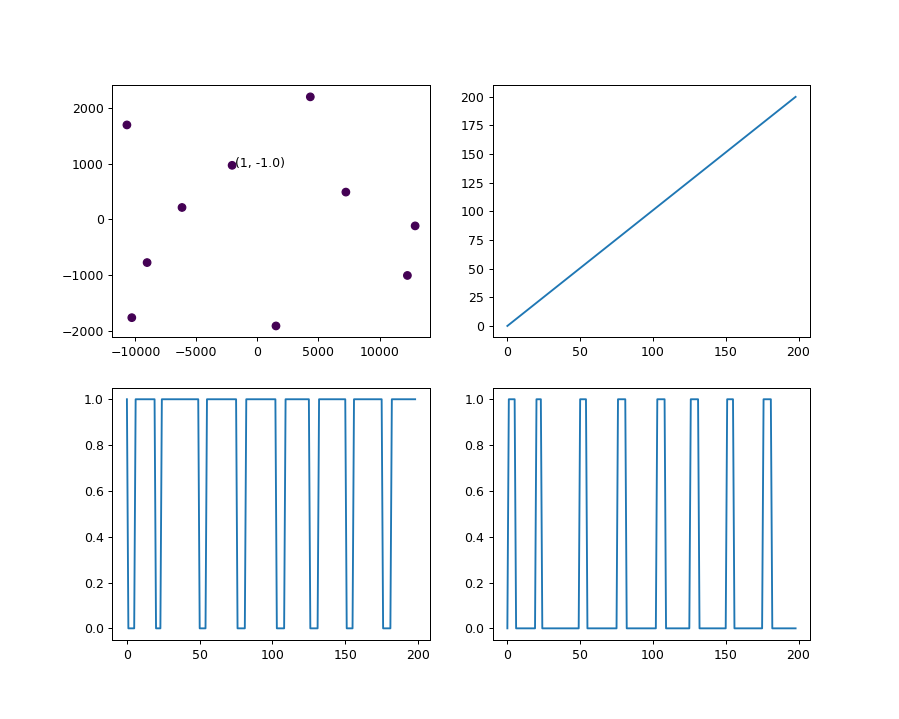

Button(description='Clear all', style=ButtonStyle())

Button(description='Submit', style=ButtonStyle())

IntSlider(value=0, max=10, min=-1)

Dropdown(description='Species plot 1:', index=3, options={'Ma': 2, 'Dr_prime': 4, 'A': 7, 'Da': 0, 'Mr': 5, 'R…

Dropdown(description='Species plot 2:', index=7, options={'Ma': 2, 'Dr_prime': 4, 'A': 7, 'Da': 0, 'Mr': 5, 'R…

Dropdown(description='Species plot 3:', options={'Ma': 2, 'Dr_prime': 4, 'A': 7, 'Da': 0, 'Mr': 5, 'R': 8, 'C'…

,alpha_A,alpha_a_prime,alpha_r,alpha_r_prime,beta_a,beta_r,delta_ma,delta_mr,delta_a,delta_r,gamma_a,gamma_r,gamma_c,Theta_a,Theta_r
0,50.098932,497.062219,0.010089,50.288398,49.934346,5.024528,9.998478,0.495915,0.991184,0.198070,1.008789,0.997974,2.019727,50.490493,100.710768
1,49.698356,503.854705,0.010070,49.747448,49.710908,5.015366,10.005501,0.504189,1.008396,0.198675,1.000062,1.006603,2.008899,49.673324,99.026359
2,50.316511,496.669828,0.010071,50.401423,49.519721,5.008385,10.067362,0.498435,1.009057,0.200525,1.007362,1.001193,1.998324,50.425435,99.511037
3,50.038657,502.151869,0.010075,49.615885,50.224805,4.999777,10.081318,0.495675,0.993512,0.198653,1.007926,0.992535,2.004477,50.488170,100.664299
4,50.214117,502.982504,0.009998,50.001598,49.791281,5.014276,10.016256,0.498985,0.998406,0.199918,0.991702,1.004985,2.001357,50.438217,99.910251
5,50.198706,495.718209,0.010066,50.189653,49.993120,4.954413,10.052711,0.503800,1.007484,0.199494,0.997486,0.999708,1.995396,50.244346,100.664445
6,50.427504,497.679246,0.010009,49.791197,50.136561,4.977565,10.005952,0.501492,1.002540,0.200791,0.992506,0.993043,2.017687,50.295476,99.385308
7,49.997293,501.321686,0.009928,49.902410,50.413781,5.005861,10.001509,0.504670,0.992710,0.200483,1.004766,0.999677,1.993377,50.141480,99.476480
8,49.645500,500.429971,0.010066,49.997573,50.190486,4.999927,9.972846,0.495233,1.005705,0.199678,0.991906,1.004509,1.998516,49.650283,100.979553
9,50.143833,495.384562,0.009923,50.297626,50.100211,5.005902,9.916145,0.497455,1.005234,0.201340,0.991342,0.992178,1.987982,50.221619,99.860485


In [67]:
interactive_scatter.interative_scatter(scatter_data=pca_data, data_class=data)